![ga4](https://www.google-analytics.com/collect?v=2&tid=G-6VDTYWLKX6&cid=1&en=page_view&sid=1&dl=statmike%2Fvertex-ai-mlops%2FApplied+Forecasting&dt=Vertex+AI+Prediction+Endpoints+for+Online+Forecasting+With+Prophet.ipynb)

# Vertex AI Prediction Endpoints for Online Forecasting With Prophet

Sometimes forecasting needs to be done in the moment to support applications like anomaly detection.  These are near real-time requirements where a given recent time-series can be used to train a forecast model that is used to predict the near-future.  The predictions can be used as baselines for the expected range of behavior for a process that is monitored. The process can then be flagged if it deviates from this forecasted expectaiton.  

Most forecasting techniques are done in batch.  For this application an online training and serving application needs to be built.  

The workflow:
- Build Forecasting Code with Prophet
- Build A Custom Prediction Routine that runs the forecasting code
- Deploy the Custom Prediction Routine to a Vertex AI Online Endpoint
- Get Forecast on-demand
- Test Scaling The Serving of forecast

---

**Prerequisites:**
- [BigQuery Time Series Forecasting Data Review and Preparation](./BigQuery%20Time%20Series%20Forecasting%20Data%20Review%20and%20Preparation.ipynb)
    - prepare data for this notebook

This uses Vertex AI [Custom Prediction Routines](https://cloud.google.com/vertex-ai/docs/predictions/custom-prediction-routines) which require an environment with Docker.  Vertex AI Workbench [User-managed notebooks](https://cloud.google.com/vertex-ai/docs/workbench/user-managed/introduction) has these requirements.

---
## Colab Setup

**This notebook uses local Docker which is not available on Colab.**

To run this notebook in Colab click [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/statmike/vertex-ai-mlops/blob/main/Applied%20Forecasting/Vertex%20AI%20Prediction%20Endpoints%20for%20Online%20Forecasting%20With%20Prophet.ipynb) and run the cells in this section.  Otherwise, skip this section.

This cell will authenticate to GCP (follow prompts in the popup).

In [1]:
PROJECT_ID = 'statmike-mlops-349915' # replace with project ID

In [2]:
try:
    import google.colab
    from google.colab import auth
    auth.authenticate_user()
    !gcloud config set project {PROJECT_ID}
except Exception:
    pass

---
## Installs and API Enablement

The clients packages may need installing in this environment.  Also, the API for Artifact Registry needs to be enabled (if not already enabled).

### Installs (If Needed)
The list `packages` contains tuples of package import names and install names.  If the import name is not found then the install name is used to install quitely for the current user.

In [611]:
# tuples of (import name, install name)
packages = [
    ('stan', 'pystan'),
    ('prophet', 'prophet'),
    ('bigframes', 'bigframes'),
    ('google.cloud.aiplatform', 'google-cloud-aiplatform'),
    ('google.cloud.artifactregistry_v1', 'google-cloud-artifact-registry')
]

import importlib
install = False
for package in packages:
    if not importlib.util.find_spec(package[0]):
        print(f'installing package {package[1]}')
        install = True
        !pip install {package[1]} -U -q --user

### Restart Kernel (If Installs Occured)

After a kernel restart the code submission can start with the next cell after this one.

In [612]:
if install:
    import IPython
    app = IPython.Application.instance()
    app.kernel.do_shutdown(True)

### API Enablement

In [613]:
!gcloud services enable artifactregistry.googleapis.com

---
## Setup

In [150]:
project = !gcloud config get-value project
PROJECT_ID = project[0]
PROJECT_ID

'statmike-mlops-349915'

In [151]:
REGION = 'us-central1'
EXPERIMENT = 'online-prophet'
SERIES = 'applied-forecasting'

In [152]:
BQ_REGION = REGION[0:2]

BQ_PROJECT = PROJECT_ID
BQ_DATASET = SERIES.replace('-','_')
BQ_TABLE = 'forecasting-data_prepped'

In [153]:
REPOSITORY = f"{REGION}-docker.pkg.dev/{PROJECT_ID}/{PROJECT_ID}"

In [154]:
import os
import json
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

from google.cloud import aiplatform
from google.cloud import artifactregistry_v1
from prophet import Prophet
import bigframes.pandas as bf

In [155]:
aiplatform.init(project = PROJECT_ID, location = REGION)
ar_client = artifactregistry_v1.ArtifactRegistryClient()

bf.reset_session()
bf.options.bigquery.project = BQ_PROJECT
bf.options.bigquery.location = BQ_REGION

In [156]:
SERVICE_ACCOUNT = !gcloud config list --format='value(core.account)' 
SERVICE_ACCOUNT = SERVICE_ACCOUNT[0]
SERVICE_ACCOUNT

'1026793852137-compute@developer.gserviceaccount.com'

In [157]:
DIR = f'temp/{EXPERIMENT}'
!rm -rf {DIR}
!mkdir -p {DIR}

---
## Time Series Data

Use the [BigFrames API](https://cloud.google.com/python/docs/reference/bigframes/latest) to work directly with the prepared time series data from BigQuery:


Link to data as dataframe:

In [158]:
df = bf.read_gbq(f"{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}")

HTML(value='Query job 0f903940-85c9-42ad-ba29-245fb09d7d37 is RUNNING. <a target="_blank" href="https://consol…

Use Pandas methods to evaluate the dataframe:

In [159]:
df.shape

HTML(value='Query job 93d4b193-9f5b-488a-88c2-bdcd2d240a6b is DONE. 0 Bytes processed. <a target="_blank" href…

(4382, 8)

In [160]:
df.dtypes

start_station_name         string[pyarrow]
starttime             date32[day][pyarrow]
num_trips                            Int64
avg_tripduration                   Float64
pct_subscriber                     Float64
ratio_gender                       Float64
capacity                             Int64
splits                     string[pyarrow]
dtype: object

Get a list of unique station names:

In [161]:
stations = df['start_station_name'].unique().tolist()
stations

HTML(value='Query job b0eb70d9-4080-4ed7-9f3d-b27656c57462 is DONE. 163.8 kB processed. <a target="_blank" hre…

['Central Park S & 6 Ave',
 'Central Park West & W 72 St',
 'Grand Army Plaza & Central Park S',
 'W 82 St & Central Park West',
 'Central Park West & W 100 St',
 'Central Park West & W 85 St',
 'Central Park North & Adam Clayton Powell Blvd',
 'Central Park West & W 76 St',
 'Central Park West & W 68 St',
 'Central Park West & W 102 St',
 'Central Park W & W 96 St',
 'W 106 St & Central Park West']

Review a single time series:

In [162]:
df[df['start_station_name'] == stations[0]].sort_values(by = ['starttime'])

HTML(value='Query job 22b020e5-5b0c-4c77-a6fa-b25e099b440b is DONE. 128.8 kB processed. <a target="_blank" hre…

HTML(value='Query job fd8ba57d-b959-4529-b9fe-200f8e2fa2eb is DONE. 403.5 kB processed. <a target="_blank" hre…

HTML(value='Query job 0b2a2069-c42e-4253-8c9e-cc8258fa35b6 is DONE. 0 Bytes processed. <a target="_blank" href…

,start_station_name,starttime,num_trips,avg_tripduration,pct_subscriber,ratio_gender,capacity,splits
1730,Central Park S & 6 Ave,2013-07-01,69,1532.144928,0.652174,1.464286,73,TRAIN
3685,Central Park S & 6 Ave,2013-07-02,180,1817.505556,0.327778,0.363636,73,TRAIN
2626,Central Park S & 6 Ave,2013-07-03,115,1615.504348,0.4,0.455696,73,TRAIN
3614,Central Park S & 6 Ave,2013-07-04,175,2225.331429,0.297143,0.241135,73,TRAIN
3881,Central Park S & 6 Ave,2013-07-05,195,2213.061538,0.215385,0.203704,73,TRAIN
4158,Central Park S & 6 Ave,2013-07-06,222,1812.40991,0.18018,0.168421,73,TRAIN
207,Central Park S & 6 Ave,2013-07-07,266,1942.007519,0.214286,0.1875,73,TRAIN
3113,Central Park S & 6 Ave,2013-07-08,143,2368.783217,0.328671,0.361905,73,TRAIN
3193,Central Park S & 6 Ave,2013-07-09,148,1942.959459,0.554054,0.741176,73,TRAIN
3095,Central Park S & 6 Ave,2013-07-10,142,1868.626761,0.514085,0.690476,73,TRAIN


---
## Prepare Data For Prophet

Prophet [expects a dataframe](https://facebook.github.io/prophet/docs/quick_start.html#python-api) for a single time series with columns `ds` for timestamp and `y` for the demand variable of the forecast. This data has multiple series, one for each station identified in the column `start_station_name`. Below is the code to create a dataframe for a given `start_station_name`.

In [163]:
stations[0]

'Central Park S & 6 Ave'

In [164]:
ts = df[(df['start_station_name'] == stations[0])][['starttime','num_trips']].rename(columns = {'starttime': 'ds', 'num_trips': 'y'}).sort_values(by = ['ds'])

In [165]:
ts.head()

HTML(value='Query job 1b47990d-b20c-42a7-8dd4-2829b018d52c is DONE. 198.9 kB processed. <a target="_blank" hre…

HTML(value='Query job cdd383b9-6339-4d02-ad98-a24236a4df8b is DONE. 234.0 kB processed. <a target="_blank" hre…

HTML(value='Query job 90ffdee8-8f0d-4950-b71e-0858e0e7b011 is DONE. 0 Bytes processed. <a target="_blank" href…

,ds,y
1730,2013-07-01,69
3685,2013-07-02,180
2626,2013-07-03,115
3614,2013-07-04,175
3881,2013-07-05,195


Move a copy of the prepared data in `ts` to a local Pandas dataframe with `to_pandas()` method.

In [166]:
local_ts = ts.to_pandas()

HTML(value='Query job 6ede731d-e6e7-4b3c-9052-c07058290289 is DONE. 234.0 kB processed. <a target="_blank" hre…

In [167]:
type(ts), type(local_ts)

(bigframes.dataframe.DataFrame, pandas.core.frame.DataFrame)

---
## Create Forecast Model For Single Time Series - Locally (In Notebook)

Fit with [seasonality](https://facebook.github.io/prophet/docs/seasonality,_holiday_effects,_and_regressors.html#specifying-custom-seasonalities) and [country holidays](https://facebook.github.io/prophet/docs/seasonality,_holiday_effects,_and_regressors.html#built-in-country-holidays) added:

In [168]:
p = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=True)
p.add_country_holidays(country_name='US')
p.fit(local_ts.iloc[0:-10])

[DEBUG][2023-09-13 16:18:39,891][cmdstanpy] input tempfile: /var/tmp/tmpsu39fmvh/36x79vzr.json
[DEBUG][2023-09-13 16:18:39,982][cmdstanpy] input tempfile: /var/tmp/tmpsu39fmvh/qcr4l32o.json
[DEBUG][2023-09-13 16:18:39,985][cmdstanpy] idx 0
[DEBUG][2023-09-13 16:18:39,986][cmdstanpy] running CmdStan, num_threads: None
[DEBUG][2023-09-13 16:18:39,988][cmdstanpy] CmdStan args: ['/opt/conda/lib/python3.10/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=51358', 'data', 'file=/var/tmp/tmpsu39fmvh/36x79vzr.json', 'init=/var/tmp/tmpsu39fmvh/qcr4l32o.json', 'output', 'file=/var/tmp/tmpsu39fmvh/prophet_model9icibk60/prophet_model-20230913161839.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:18:39 - cmdstanpy - INFO - Chain [1] start processing
[INFO][2023-09-13 16:18:39,989][cmdstanpy] Chain [1] start processing
16:18:40 - cmdstanpy - INFO - Chain [1] done processing
[INFO][2023-09-13 16:18:40,108][cmdstanpy] Chain [1] done processing


Make dataframe for forecast by adding periods to the known date range of the training data. If you only want the forecast horizone then use the option `include_history = False`.

In [169]:
future = p.make_future_dataframe(periods = 10, include_history = False)
future.head()

,ds
0,2016-09-21
1,2016-09-22
2,2016-09-23
3,2016-09-24
4,2016-09-25


Generate the predictions for the forecast horizon. Since we kept the default that include the training history dates, we also get fit information for each of these dates.

In [170]:
forecast = p.predict(future)
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Christmas Day,Christmas Day_lower,Christmas Day_upper,Christmas Day (Observed),...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2016-09-21,205.394458,199.324752,355.976227,205.394458,205.394458,0.0,0.0,0.0,0.0,...,-26.262949,-26.262949,-26.262949,67.651145,67.651145,67.651145,0.0,0.0,0.0,275.914527
1,2016-09-22,205.571977,190.937098,342.271557,205.571977,205.571977,0.0,0.0,0.0,0.0,...,-27.763270,-27.763270,-27.763270,63.358203,63.358203,63.358203,0.0,0.0,0.0,270.298783
2,2016-09-23,205.749495,206.145140,355.022949,205.749495,205.749495,0.0,0.0,0.0,0.0,...,-14.941284,-14.941284,-14.941284,59.073835,59.073835,59.073835,0.0,0.0,0.0,279.013919
3,2016-09-24,205.927014,265.137873,410.914439,205.927014,205.927014,0.0,0.0,0.0,0.0,...,52.400292,52.400292,52.400292,54.858218,54.858218,54.858218,0.0,0.0,0.0,342.317396
4,2016-09-25,206.104533,263.123899,420.492772,206.104533,206.104533,0.0,0.0,0.0,0.0,...,58.748149,58.748149,58.748149,50.769108,50.769108,50.769108,0.0,0.0,0.0,344.753662


Use the built in plotting capabilites of Prophet to review the time series with forecast:

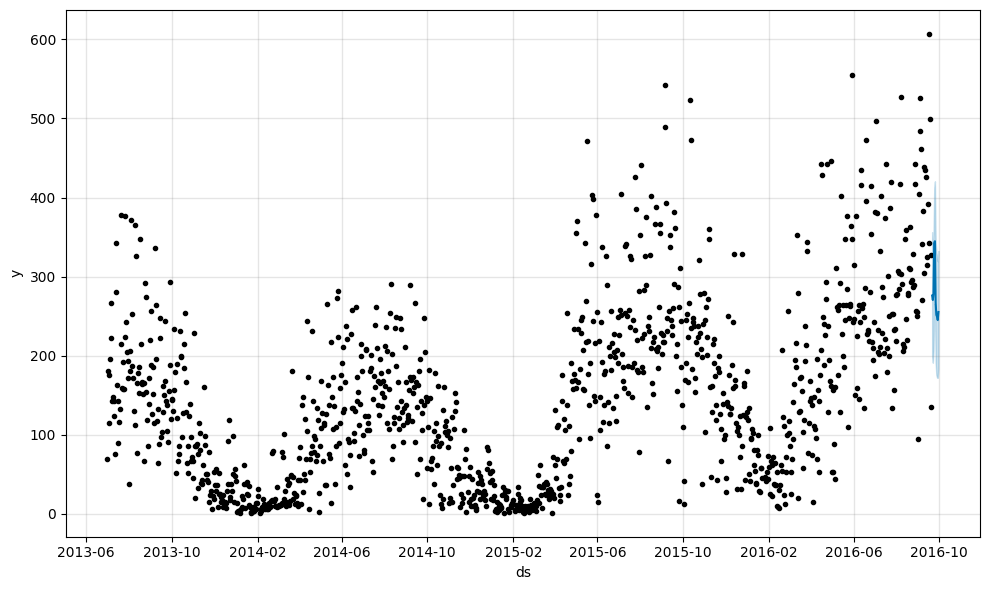

In [171]:
p.plot(forecast);

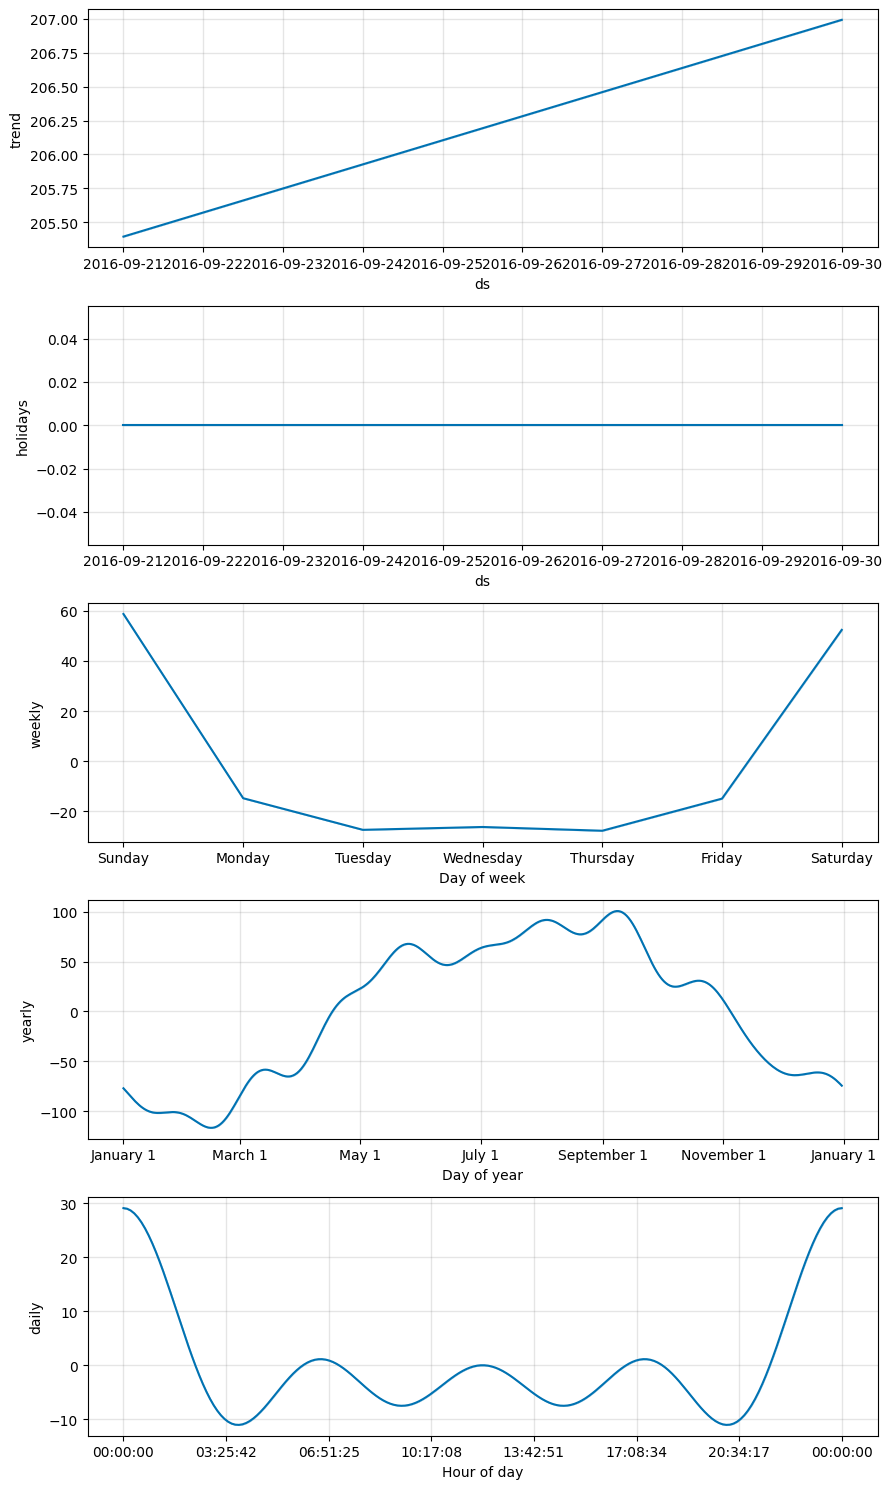

In [172]:
p.plot_components(forecast);

### Review Results

In [173]:
results = local_ts.merge(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].astype(local_ts[['ds']].dtypes.to_dict()), how = 'outer', left_on = 'ds', right_on = 'ds')
results.iloc[-15:]

,ds,y,yhat,yhat_lower,yhat_upper
1162,2016-09-16,343,NaN,NaN,NaN
1163,2016-09-17,607,NaN,NaN,NaN
1164,2016-09-18,499,NaN,NaN,NaN
1165,2016-09-19,135,NaN,NaN,NaN
1166,2016-09-20,327,NaN,NaN,NaN
1167,2016-09-21,403,275.914527,199.324752,355.976227
1168,2016-09-22,351,270.298783,190.937098,342.271557
1169,2016-09-23,354,279.013919,206.145140,355.022949
1170,2016-09-24,399,342.317396,265.137873,410.914439
1171,2016-09-25,402,344.753662,263.123899,420.492772


In [174]:
results.dtypes

ds            date32[day][pyarrow]
y                            Int64
yhat                       float64
yhat_lower                 float64
yhat_upper                 float64
dtype: object

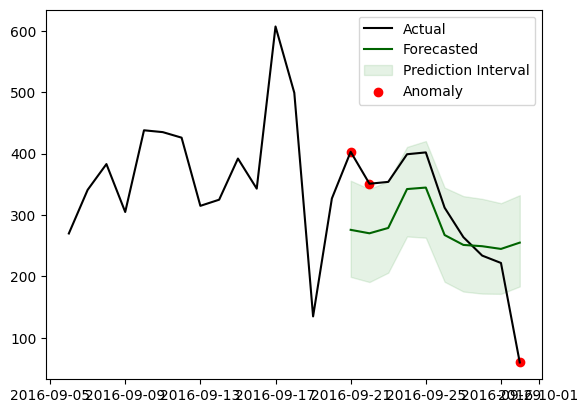

In [175]:
r_results = results[-25:]
fig, ax = plt.subplots()
ax.plot(r_results['ds'], r_results['y'], color = 'black', label = 'Actual')
ax.plot(r_results['ds'], r_results['yhat'], color = 'darkgreen', label = 'Forecasted')
ax.fill_between(r_results['ds'], r_results['yhat_lower'], r_results['yhat_upper'], color = 'green', alpha = .1, label = 'Prediction Interval')
anomaly = r_results[(r_results['y'] < r_results['yhat_lower']) | (r_results['y'] > r_results['yhat_upper'])]
ax.scatter(anomaly['ds'], anomaly['y'], color = 'red', label = 'Anomaly')

ax.legend(loc='best')

---
## Build Custom Prediction Routine

[Custom Prediction Routine](https://cloud.google.com/vertex-ai/docs/predictions/custom-prediction-routines) - A custom container built by the Vertex AI SDK that assist with pre/post processing code without the need to setup an HTTP server.

Resources:
- [Class Predictor in SDK](https://cloud.google.com/python/docs/reference/aiplatform/latest/google.cloud.aiplatform.prediction.Predictor)
- [Class Predictor Interface (GitHub)](https://github.com/googleapis/python-aiplatform/blob/main/google/cloud/aiplatform/prediction/predictor.py)

Make a local folder for source code:

In [176]:
!mkdir -p {DIR}/SRC

Create a `requirements.txt` file with the required Python packages:

In [692]:
%%writefile {DIR}/SRC/requirements.txt
fastapi
uvicorn==0.17.6
pandas
google-cloud-aiplatform[prediction]>=1.16.0
pystan
prophet

Writing temp/online-prophet/SRC/requirements.txt


Create a `predictor.py` file with the prediction routine:

In [693]:
%%writefile {DIR}/SRC/predictor.py

# packages
from google.cloud.aiplatform.prediction.predictor import Predictor
from prophet import Prophet
import pandas as pd

def forecast(input_ts):
    
    read_ts = pd.DataFrame(input_ts, columns = ['ds', 'y'])
    read_ts['ds'] = pd.to_datetime(read_ts['ds'])
    
    p = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=True)
    p.add_country_holidays(country_name='US')
    p.fit(read_ts)
    
    future = p.make_future_dataframe(periods = 10, include_history = False)
    forecast = p.predict(future)
    
    forecast['ds'] = forecast['ds'].dt.strftime('%Y/%m/%d')
    forecast = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].to_dict(orient = 'records')
    
    return forecast
    
class CprPredictor(Predictor):
    def __init__(self):
        return
    
    def load(self, artifacts_uri: str) -> None:
        # no model to load here, this example trains a model and returns predictions/forecast
        pass
        
    def predict(self, instances):
        
        instances = instances['instances']
        results = [forecast(instance) for instance in instances]
        
        # note that Vertex AI Endpoints expect the response to be named "predictions"
        return {"predictions": results}

Writing temp/online-prophet/SRC/predictor.py


---
## Format Data For Passing To/From Endpoint

### Examine Current Form: DataFrame

In [27]:
type(local_ts), local_ts.dtypes

(pandas.core.frame.DataFrame,
 ds    date32[day][pyarrow]
 y                    Int64
 dtype: object)

In [28]:
local_ts.head()

,ds,y
1730,2013-07-01,69
3685,2013-07-02,180
2626,2013-07-03,115
3614,2013-07-04,175
3881,2013-07-05,195


### Convert Data Types And Format As List

Data passed to Vertex AI Endpoints is expected in the format of ML features - like int, str, float.  Converting the dates to strings bypasses this restriction.  The custom predictor logic can first convert these strings back to dates.

Reference:
- [Format your input for online prediction](https://cloud.google.com/vertex-ai/docs/predictions/get-online-predictions)

In [29]:
input_ts = local_ts.copy()
input_ts['ds'] = local_ts['ds'].dt.strftime('%Y/%m/%d')

In [30]:
input_ts.head()

,ds,y
1730,2013/07/01,69
3685,2013/07/02,180
2626,2013/07/03,115
3614,2013/07/04,175
3881,2013/07/05,195


In [31]:
input_ts.dtypes

ds    string[pyarrow]
y               Int64
dtype: object

Format as List For Instances

In [32]:
input_ts = input_ts.values.tolist()

In [33]:
input_ts[0:2]

[['2013/07/01', 69], ['2013/07/02', 180]]

### Make DataFrame From Instance (List)

How to return the data to a dataframe:

In [34]:
read_ts = pd.DataFrame(input_ts, columns = ['ds', 'y'])

In [35]:
read_ts['ds'] = pd.to_datetime(read_ts['ds'])
read_ts.dtypes

ds    datetime64[ns]
y              int64
dtype: object

In [36]:
read_ts.head()

,ds,y
0,2013-07-01,69
1,2013-07-02,180
2,2013-07-03,115
3,2013-07-04,175
4,2013-07-05,195


---
## Run Custom Prediction Routine - Locally (In Notebook)

Build a local model from a custom predictor with [aiplatform.prediction.LocalModel.build_cpr_model()](https://cloud.google.com/python/docs/reference/aiplatform/latest/google.cloud.aiplatform.prediction.LocalModel#google_cloud_aiplatform_prediction_LocalModel_build_cpr_model).

In [704]:
from google.cloud.aiplatform.prediction import LocalModel

# load the local predictor class and call it CprPreditor:
predictor = importlib.import_module(f"temp.{EXPERIMENT}.SRC.predictor")

In [705]:
local_model = LocalModel.build_cpr_model(
    src_dir = f"{DIR}/SRC",
    output_image_uri = f"{REPOSITORY}/{SERIES}_{EXPERIMENT}",
    predictor = predictor.CprPredictor,
    requirements_path = f"{DIR}/SRC/requirements.txt",
)

[INFO][2023-09-11 14:27:41,821][google.cloud.aiplatform.docker_utils.build] Running command: docker build -t us-central1-docker.pkg.dev/statmike-mlops-349915/statmike-mlops-349915/applied-forecasting_online-prophet --rm -f- temp/online-prophet/SRC
/opt/conda/lib/python3.10/subprocess.py:955: RuntimeWarning: line buffering (buffering=1) isn't supported in binary mode, the default buffer size will be used
  self.stdin = io.open(p2cwrite, 'wb', bufsize)
/opt/conda/lib/python3.10/subprocess.py:961: RuntimeWarning: line buffering (buffering=1) isn't supported in binary mode, the default buffer size will be used
  self.stdout = io.open(c2pread, 'rb', bufsize)
[INFO][2023-09-11 14:27:47,957][google.cloud.aiplatform.docker_utils.local_util] Sending build context to Docker daemon  5.382kB
[INFO][2023-09-11 14:27:47,959][google.cloud.aiplatform.docker_utils.local_util] 

[INFO][2023-09-11 14:27:48,145][google.cloud.aiplatform.docker_utils.local_util] Step 1/14 : FROM python:3.7

[INFO][2023-09-1

In [706]:
local_model.get_serving_container_spec()

image_uri: "us-central1-docker.pkg.dev/statmike-mlops-349915/statmike-mlops-349915/applied-forecasting_online-prophet"
predict_route: "/predict"
health_route: "/health"

### Try Forecasting With Local Model:

Depoy the model locally for testing with [aiplatform.prediction.LocalModel.deploy_to_local_endpoint()](https://cloud.google.com/python/docs/reference/aiplatform/latest/google.cloud.aiplatform.prediction.LocalModel#google_cloud_aiplatform_prediction_LocalModel_build_cpr_model):

In [707]:
with local_model.deploy_to_local_endpoint() as local_endpoint:
    predict_response = local_endpoint.predict(
        request = json.dumps(dict(instances = [input_ts])),
        headers = {"Content-Type": "application/json"}
    )
    health_check_response = local_endpoint.run_health_check()

[INFO][2023-09-11 14:30:12,958][google.cloud.aiplatform.prediction.local_endpoint] Got the project id from the global config: statmike-mlops-349915.


Review the health check response:

In [708]:
health_check_response, health_check_response.content

(<Response [200]>, b'{}')

Review the predict response:

In [709]:
predict_response

<Response [200]>

In [710]:
print(predict_response.content)

b'{"predictions": [[{"ds": "2016/10/01", "yhat": 323.24942163513174, "yhat_lower": 246.0809112829725, "yhat_upper": 403.30006413509193}, {"ds": "2016/10/02", "yhat": 327.34355541587746, "yhat_lower": 255.15403424985038, "yhat_upper": 408.0307028339283}, {"ds": "2016/10/03", "yhat": 251.89487344740698, "yhat_lower": 179.07048584189292, "yhat_upper": 324.3456176694174}, {"ds": "2016/10/04", "yhat": 237.58926098856543, "yhat_lower": 161.9410188718192, "yhat_upper": 311.85044546868176}, {"ds": "2016/10/05", "yhat": 238.23333191195738, "yhat_lower": 162.94183961623813, "yhat_upper": 307.732835003491}, {"ds": "2016/10/06", "yhat": 235.7242215386963, "yhat_lower": 156.3127653671513, "yhat_upper": 313.86628596258504}, {"ds": "2016/10/07", "yhat": 247.17952874345588, "yhat_lower": 169.02136856724718, "yhat_upper": 316.8470415507512}, {"ds": "2016/10/08", "yhat": 315.5151588106661, "yhat_lower": 239.78217640094698, "yhat_upper": 391.49650735393965}, {"ds": "2016/10/09", "yhat": 322.1058137408267

Transform the predict response to a dataframe of forecasted values:

In [711]:
forecast = [pd.DataFrame.from_dict(response) for response in json.loads(predict_response.content)['predictions']][0]
forecast

,ds,yhat,yhat_lower,yhat_upper
0,2016/10/01,323.249422,246.080911,403.300064
1,2016/10/02,327.343555,255.154034,408.030703
2,2016/10/03,251.894873,179.070486,324.345618
3,2016/10/04,237.589261,161.941019,311.850445
4,2016/10/05,238.233332,162.941840,307.732835
5,2016/10/06,235.724222,156.312765,313.866286
6,2016/10/07,247.179529,169.021369,316.847042
7,2016/10/08,315.515159,239.782176,391.496507
8,2016/10/09,322.105814,251.841247,401.365079
9,2016/10/10,374.466889,300.742405,451.332990


In [712]:
forecast['ds'] = pd.to_datetime(forecast['ds'])
forecast

,ds,yhat,yhat_lower,yhat_upper
0,2016-10-01,323.249422,246.080911,403.300064
1,2016-10-02,327.343555,255.154034,408.030703
2,2016-10-03,251.894873,179.070486,324.345618
3,2016-10-04,237.589261,161.941019,311.850445
4,2016-10-05,238.233332,162.941840,307.732835
5,2016-10-06,235.724222,156.312765,313.866286
6,2016-10-07,247.179529,169.021369,316.847042
7,2016-10-08,315.515159,239.782176,391.496507
8,2016-10-09,322.105814,251.841247,401.365079
9,2016-10-10,374.466889,300.742405,451.332990


---
## Host Model To Vertex AI Online Endpoint

First, configure `gcloud` as the credential helper for Google Cloud Docker registries:

In [713]:
!gcloud auth configure-docker {REGION}-docker.pkg.dev --quiet


{
  "credHelpers": {
    "gcr.io": "gcloud",
    "us.gcr.io": "gcloud",
    "eu.gcr.io": "gcloud",
    "asia.gcr.io": "gcloud",
    "staging-k8s.gcr.io": "gcloud",
    "marketplace.gcr.io": "gcloud",
    "us-central1-docker.pkg.dev": "gcloud"
  }
}
Adding credentials for: us-central1-docker.pkg.dev
gcloud credential helpers already registered correctly.


### Create Docker Image Repository

Create an Artifact Registry Repository to hold Docker Images created by this notebook. First, check to see if it is already created by a previous run and retrieve it if it has. Otherwise, create!

Name the repository the same name as the `PROJECT_ID`.

In [714]:
docker_repo = None
for repo in ar_client.list_repositories(parent = f'projects/{PROJECT_ID}/locations/{REGION}'):
    if f'{PROJECT_ID}' == repo.name.split('/')[-1]:
        docker_repo = repo
        print(f'Retrieved existing repo: {docker_repo.name}')

if not docker_repo:
    operation = ar_client.create_repository(
        request = artifactregistry_v1.CreateRepositoryRequest(
            parent = f'projects/{PROJECT_ID}/locations/{REGION}',
            repository_id = f'{PROJECT_ID}',
            repository = artifactregistry_v1.Repository(
                description = f'A repository for the {EXPERIMENT} experiment that holds docker images.',
                name = f'{PROJECT_ID}',
                format_ = artifactregistry_v1.Repository.Format.DOCKER,
                labels = {'series': SERIES, 'experiment': EXPERIMENT}
            )
        )
    )
    print('Creating Repository ...')
    docker_repo = operation.result()
    print(f'Completed creating repo: {docker_repo.name}')

Retrieved existing repo: projects/statmike-mlops-349915/locations/us-central1/repositories/statmike-mlops-349915


In [715]:
docker_repo.name, docker_repo.format_.name

('projects/statmike-mlops-349915/locations/us-central1/repositories/statmike-mlops-349915',
 'DOCKER')

In [716]:
REPOSITORY = f"{REGION}-docker.pkg.dev/{PROJECT_ID}/{docker_repo.name.split('/')[-1]}"
REPOSITORY

'us-central1-docker.pkg.dev/statmike-mlops-349915/statmike-mlops-349915'

### Push model to Artifact Registry

The `local_model` was already given the repository address with parameter `output_image_uri` at definition above.  Use [aiplatform.prediction.LocalModel.push_image()](https://cloud.google.com/python/docs/reference/aiplatform/latest/google.cloud.aiplatform.prediction.LocalModel#google_cloud_aiplatform_prediction_LocalModel_push_image) to push the image from local to artifact registry:

In [717]:
local_model.push_image()

/opt/conda/lib/python3.10/subprocess.py:955: RuntimeWarning: line buffering (buffering=1) isn't supported in binary mode, the default buffer size will be used
  self.stdin = io.open(p2cwrite, 'wb', bufsize)
/opt/conda/lib/python3.10/subprocess.py:961: RuntimeWarning: line buffering (buffering=1) isn't supported in binary mode, the default buffer size will be used
  self.stdout = io.open(c2pread, 'rb', bufsize)
[INFO][2023-09-11 14:31:00,518][google.cloud.aiplatform.docker_utils.local_util] Using default tag: latest

[INFO][2023-09-11 14:31:01,420][google.cloud.aiplatform.docker_utils.local_util] The push refers to repository [us-central1-docker.pkg.dev/statmike-mlops-349915/statmike-mlops-349915/applied-forecasting_online-prophet]

[INFO][2023-09-11 14:31:01,438][google.cloud.aiplatform.docker_utils.local_util] 65ab833ef835: Preparing

[INFO][2023-09-11 14:31:01,439][google.cloud.aiplatform.docker_utils.local_util] d72bf480b6cc: Preparing

[INFO][2023-09-11 14:31:01,440][google.cloud.a

In [718]:
print(f'Review the image in artifact registry here:\nhttps://console.cloud.google.com/artifacts/docker/{PROJECT_ID}/{REGION}/{PROJECT_ID}/{SERIES}_{EXPERIMENT}?project={PROJECT_ID}')

Review the image in artifact registry here:
https://console.cloud.google.com/artifacts/docker/statmike-mlops-349915/us-central1/statmike-mlops-349915/applied-forecasting_online-prophet?project=statmike-mlops-349915


### Register model in Vertex AI Model Registry

In [177]:
modelmatch = aiplatform.Model.list(filter = f'display_name={SERIES}_{EXPERIMENT}')

upload_model = True
if modelmatch:
    print("Model Already in Registry:")
    print('Loading model as new default version.')
    parent_model = modelmatch[0].resource_name
else:
    print('This is a new model, creating in model registry')
    parent_model = ''

Model Already in Registry:
Loading model as new default version.


In [178]:
#model = modelmatch[0]

In [720]:
if upload_model:
    model = aiplatform.Model.upload(
        local_model = local_model,
        display_name = f'{SERIES}_{EXPERIMENT}',
        model_id = f'model_{SERIES}_{EXPERIMENT}',
        parent_model =  parent_model,
        is_default_version = True,
        labels = {'series' : f'{SERIES}', 'experiment' : f'{EXPERIMENT}'}        
    )

Creating Model


[INFO][2023-09-11 14:31:30,737][google.cloud.aiplatform.models] Creating Model


Create Model backing LRO: projects/1026793852137/locations/us-central1/models/2453272125335666688/operations/538920882710511616


[INFO][2023-09-11 14:31:30,739][google.cloud.aiplatform.models] Create Model backing LRO: projects/1026793852137/locations/us-central1/models/2453272125335666688/operations/538920882710511616


Model created. Resource name: projects/1026793852137/locations/us-central1/models/2453272125335666688@4


[INFO][2023-09-11 14:33:28,135][google.cloud.aiplatform.models] Model created. Resource name: projects/1026793852137/locations/us-central1/models/2453272125335666688@4


To use this Model in another session:


[INFO][2023-09-11 14:33:28,137][google.cloud.aiplatform.models] To use this Model in another session:


model = aiplatform.Model('projects/1026793852137/locations/us-central1/models/2453272125335666688@4')


[INFO][2023-09-11 14:33:28,139][google.cloud.aiplatform.models] model = aiplatform.Model('projects/1026793852137/locations/us-central1/models/2453272125335666688@4')


In [179]:
model.version_id

'4'

### Create/Retrieve The Endpoint For This Series

Reference:
- [aiplatform.Endpoint](https://cloud.google.com/python/docs/reference/aiplatform/latest/google.cloud.aiplatform.Endpoint)

In [180]:
endpoints = aiplatform.Endpoint.list(filter = f"labels.series={SERIES}")
if endpoints:
    endpoint = endpoints[0]
    print(f"Endpoint Exists: {endpoints[0].resource_name}")
else:
    endpoint = aiplatform.Endpoint.create(
        display_name = f"{SERIES}",
        labels = {'series' : f"{SERIES}"}    
    )
    print(f"Endpoint Created: {endpoint.resource_name}")
    
print(f'Review the Endpoint in the Console:\nhttps://console.cloud.google.com/vertex-ai/locations/{REGION}/endpoints/{endpoint.name}?project={PROJECT_ID}')

Creating Endpoint


[INFO][2023-09-13 16:19:59,047][google.cloud.aiplatform.models] Creating Endpoint


Create Endpoint backing LRO: projects/1026793852137/locations/us-central1/endpoints/7440441364648558592/operations/5864761693610967040


[INFO][2023-09-13 16:19:59,049][google.cloud.aiplatform.models] Create Endpoint backing LRO: projects/1026793852137/locations/us-central1/endpoints/7440441364648558592/operations/5864761693610967040


Endpoint created. Resource name: projects/1026793852137/locations/us-central1/endpoints/7440441364648558592


[INFO][2023-09-13 16:20:01,058][google.cloud.aiplatform.models] Endpoint created. Resource name: projects/1026793852137/locations/us-central1/endpoints/7440441364648558592


To use this Endpoint in another session:


[INFO][2023-09-13 16:20:01,060][google.cloud.aiplatform.models] To use this Endpoint in another session:


endpoint = aiplatform.Endpoint('projects/1026793852137/locations/us-central1/endpoints/7440441364648558592')


[INFO][2023-09-13 16:20:01,062][google.cloud.aiplatform.models] endpoint = aiplatform.Endpoint('projects/1026793852137/locations/us-central1/endpoints/7440441364648558592')


Endpoint Created: projects/1026793852137/locations/us-central1/endpoints/7440441364648558592
Review the Endpoint in the Console:
https://console.cloud.google.com/vertex-ai/locations/us-central1/endpoints/7440441364648558592?project=statmike-mlops-349915


### Deploy model to Vertex AI Prediction Endpoint

Deploy with either:
- [aiplatform.Endpoint.deploy(model = model)](https://cloud.google.com/python/docs/reference/aiplatform/latest/google.cloud.aiplatform.Endpoint#google_cloud_aiplatform_Endpoint_deploy)
- [aiplatform.Model.deploy(endpoint = endpoint)](https://cloud.google.com/python/docs/reference/aiplatform/latest/google.cloud.aiplatform.Model#google_cloud_aiplatform_Model_deploy)

In [181]:
print(f'Deploying model with 100% of traffic...')
endpoint.deploy(
    model = model,
    deployed_model_display_name = model.display_name,
    traffic_percentage = 100,
    machine_type = 'n1-standard-2',
    min_replica_count = 1,
    max_replica_count = 3,
    service_account = SERVICE_ACCOUNT
)

Deploying model with 100% of traffic...
Deploying Model projects/1026793852137/locations/us-central1/models/2453272125335666688 to Endpoint : projects/1026793852137/locations/us-central1/endpoints/7440441364648558592


[INFO][2023-09-13 16:20:01,152][google.cloud.aiplatform.models] Deploying Model projects/1026793852137/locations/us-central1/models/2453272125335666688 to Endpoint : projects/1026793852137/locations/us-central1/endpoints/7440441364648558592


Deploy Endpoint model backing LRO: projects/1026793852137/locations/us-central1/endpoints/7440441364648558592/operations/7925158523132968960


[INFO][2023-09-13 16:20:01,265][google.cloud.aiplatform.models] Deploy Endpoint model backing LRO: projects/1026793852137/locations/us-central1/endpoints/7440441364648558592/operations/7925158523132968960


Endpoint model deployed. Resource name: projects/1026793852137/locations/us-central1/endpoints/7440441364648558592


[INFO][2023-09-13 16:25:26,063][google.cloud.aiplatform.models] Endpoint model deployed. Resource name: projects/1026793852137/locations/us-central1/endpoints/7440441364648558592


### Remove Deployed Models without Traffic

In [182]:
for deployed_model in endpoint.list_models():
    if deployed_model.id in endpoint.traffic_split:
        print(f"Model {deployed_model.display_name} with version {deployed_model.model_version_id} has traffic = {endpoint.traffic_split[deployed_model.id]}")
    else:
        endpoint.undeploy(deployed_model_id = deployed_model.id)
        print(f"Undeploying {deployed_model.display_name} with version {deployed_model.model_version_id} because it has no traffic.")

Model applied-forecasting_online-prophet with version 4 has traffic = 100


---
## Get Online Predictions

### A Single Instance

In [183]:
local_ts = df[(df['start_station_name'] == stations[0])][['starttime','num_trips']].rename(columns = {'starttime': 'ds', 'num_trips': 'y'}).sort_values(by = ['ds']).to_pandas()

HTML(value='Query job bfec409c-ccc9-47a6-9e72-4a445cc3c593 is DONE. 234.0 kB processed. <a target="_blank" hre…

In [184]:
input_ts = local_ts[0:-10].copy()
input_ts['ds'] = local_ts['ds'].dt.strftime('%Y/%m/%d')
input_ts = input_ts.values.tolist()

In [185]:
prediction = endpoint.predict(instances = [input_ts])

In [186]:
prediction.predictions[0][0:2]

[{'yhat': 275.9145266766327,
  'yhat_lower': 206.1006743238447,
  'ds': '2016/09/21',
  'yhat_upper': 353.2732027288436},
 {'yhat_lower': 190.7705636639104,
  'yhat_upper': 349.215854028028,
  'ds': '2016/09/22',
  'yhat': 270.2987828825526}]

In [187]:
forecast = pd.DataFrame.from_dict(prediction.predictions[0])
forecast['ds'] = pd.to_datetime(forecast['ds'])
forecast

,yhat,yhat_lower,ds,yhat_upper
0,275.914527,206.100674,2016-09-21,353.273203
1,270.298783,190.770564,2016-09-22,349.215854
2,279.013919,206.340384,2016-09-23,352.347175
3,342.317396,266.377984,2016-09-24,424.041717
4,344.753662,264.032269,2016-09-25,420.997108
5,267.493303,198.510826,2016-09-26,344.329318
6,251.373442,174.570678,2016-09-27,330.474293
7,249.281977,174.073135,2016-09-28,326.153759
8,244.862855,164.457578,2016-09-29,316.289105
9,255.104459,178.508809,2016-09-30,333.359765


In [188]:
results = local_ts[-25:].merge(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].astype(local_ts[['ds']].dtypes.to_dict()), how = 'outer', left_on = 'ds', right_on = 'ds')
results.iloc[-15:]

,ds,y,yhat,yhat_lower,yhat_upper
10,2016-09-16,343,NaN,NaN,NaN
11,2016-09-17,607,NaN,NaN,NaN
12,2016-09-18,499,NaN,NaN,NaN
13,2016-09-19,135,NaN,NaN,NaN
14,2016-09-20,327,NaN,NaN,NaN
15,2016-09-21,403,275.914527,206.100674,353.273203
16,2016-09-22,351,270.298783,190.770564,349.215854
17,2016-09-23,354,279.013919,206.340384,352.347175
18,2016-09-24,399,342.317396,266.377984,424.041717
19,2016-09-25,402,344.753662,264.032269,420.997108


In [189]:
anomaly = results[(results['y'] < results['yhat_lower']) | (results['y'] > results['yhat_upper'])]

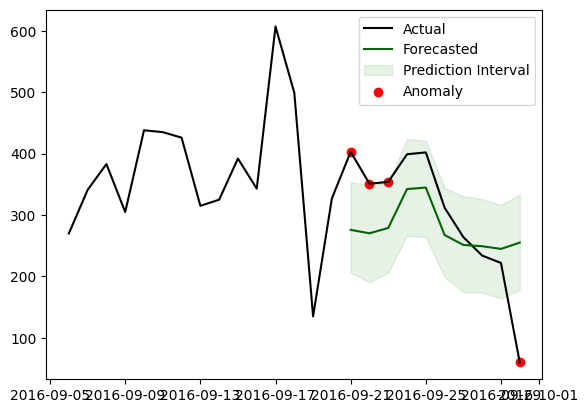

In [190]:
fig, ax = plt.subplots()
ax.plot(results['ds'], results['y'], color = 'black', label = 'Actual')
ax.plot(results['ds'], results['yhat'], color = 'darkgreen', label = 'Forecasted')
ax.fill_between(results['ds'], results['yhat_lower'], results['yhat_upper'], color = 'green', alpha = .1, label = 'Prediction Interval')
ax.scatter(anomaly['ds'], anomaly['y'], color = 'red', label = 'Anomaly')
ax.legend(loc='best')
fig.show()

### Multiple Instances - Different Time Series

In [191]:
stations

['Central Park S & 6 Ave',
 'Central Park West & W 72 St',
 'Grand Army Plaza & Central Park S',
 'W 82 St & Central Park West',
 'Central Park West & W 100 St',
 'Central Park West & W 85 St',
 'Central Park North & Adam Clayton Powell Blvd',
 'Central Park West & W 76 St',
 'Central Park West & W 68 St',
 'Central Park West & W 102 St',
 'Central Park W & W 96 St',
 'W 106 St & Central Park West']

In [192]:
local_ts = [df[(df['start_station_name'] == station) & (df['splits'] != 'TEST')][['starttime','num_trips']].rename(columns = {'starttime': 'ds', 'num_trips': 'y'}).sort_values(by = ['ds']).to_pandas() for station in stations[1:3]]

HTML(value='Query job d9bea4e4-11e0-4396-b664-9143ed0392b3 is DONE. 265.0 kB processed. <a target="_blank" hre…

HTML(value='Query job 682c4a40-7cef-4caf-afcf-b80d5d58c3c6 is DONE. 265.0 kB processed. <a target="_blank" hre…

In [193]:
input_ts = [lts[0:-10].copy() for lts in local_ts]
for i in input_ts:
    i['ds'] = i['ds'].dt.strftime('%Y/%m/%d')
input_ts = [i.values.tolist() for i in input_ts]

In [194]:
predictions = endpoint.predict(instances = input_ts)

In [195]:
forecasts = [pd.DataFrame.from_dict(prediction) for prediction in predictions.predictions]

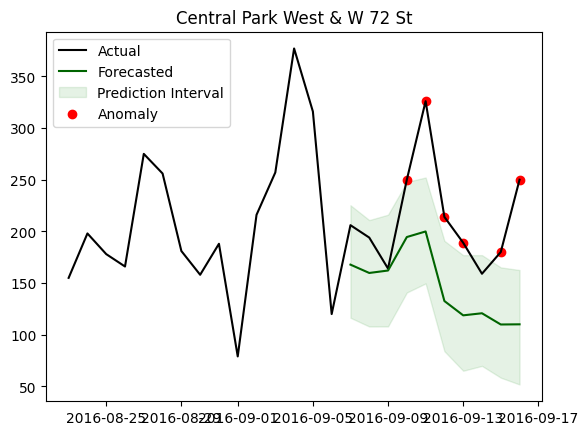

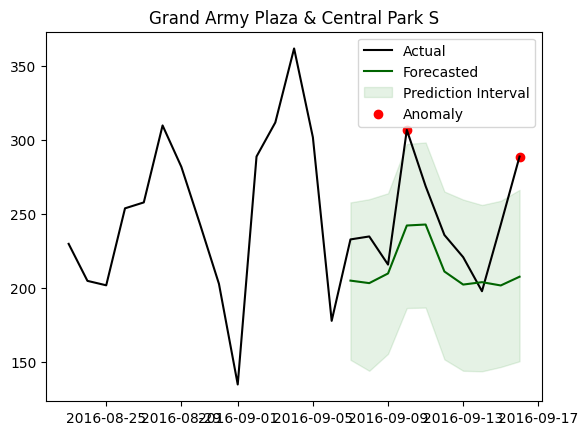

In [196]:
for i in range(len(input_ts)):
    forecasts[i]['ds'] = pd.to_datetime(forecasts[i]['ds'])
    results = local_ts[i][-25:].merge(forecasts[i][['ds', 'yhat', 'yhat_lower', 'yhat_upper']].astype(local_ts[i][['ds']].dtypes.to_dict()), how = 'outer', left_on = 'ds', right_on = 'ds')
    anomaly = results[(results['y'] < results['yhat_lower']) | (results['y'] > results['yhat_upper'])]
    fig, ax = plt.subplots()
    ax.set_title(f'{stations[i+1]}')
    ax.plot(results['ds'], results['y'], color = 'black', label = 'Actual')
    ax.plot(results['ds'], results['yhat'], color = 'darkgreen', label = 'Forecasted')
    ax.fill_between(results['ds'], results['yhat_lower'], results['yhat_upper'], color = 'green', alpha = .1, label = 'Prediction Interval')
    ax.scatter(anomaly['ds'], anomaly['y'], color = 'red', label = 'Anomaly')
    ax.legend(loc='best')
    fig.show()

### Multiple Instances - Different history lengths

In [197]:
local_ts = df[(df['start_station_name'] == stations[0])][['starttime','num_trips']].rename(columns = {'starttime': 'ds', 'num_trips': 'y'}).sort_values(by = ['ds']).to_pandas()

HTML(value='Query job c6593707-8827-4b3a-9bca-e1209d665e58 is DONE. 234.0 kB processed. <a target="_blank" hre…

In [198]:
input_ts = local_ts[0:-10].copy()
input_ts['ds'] = local_ts['ds'].dt.strftime('%Y/%m/%d')
input_ts = input_ts.values.tolist()

In [200]:
len(input_ts), input_ts[0]

(1167, ['2013/07/01', 69])

In [221]:
history_sizes = [('full', 0), ('month', 30), ('quarter', 90), ('half', 180), ('year', 365)]

In [222]:
predictions = endpoint.predict(instances = [input_ts[-1*h[1]:] for h in history_sizes])

In [223]:
forecasts = [pd.DataFrame.from_dict(prediction) for prediction in predictions.predictions]

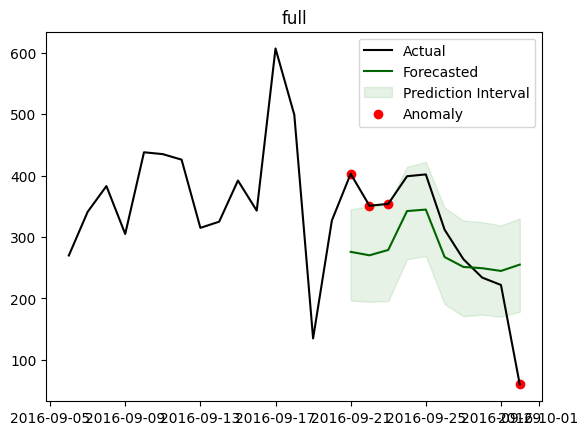

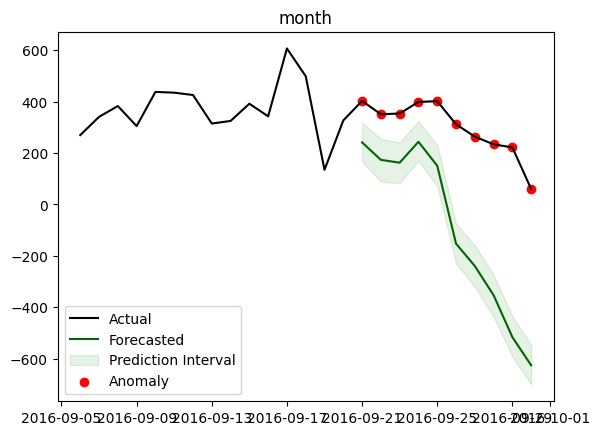

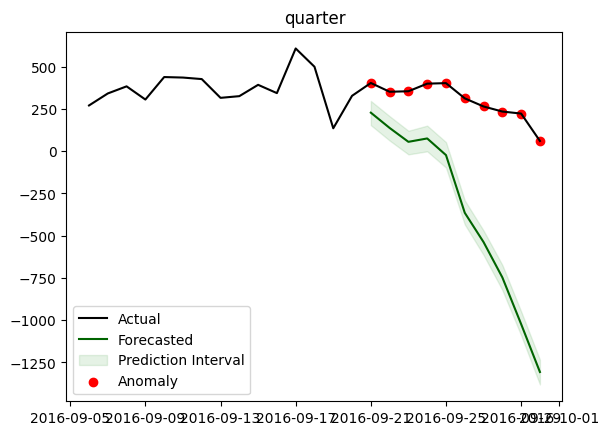

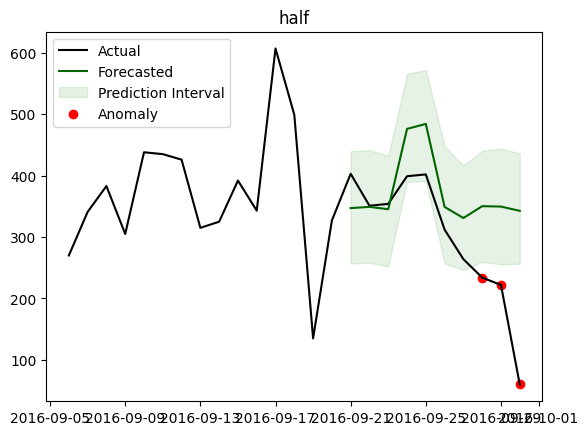

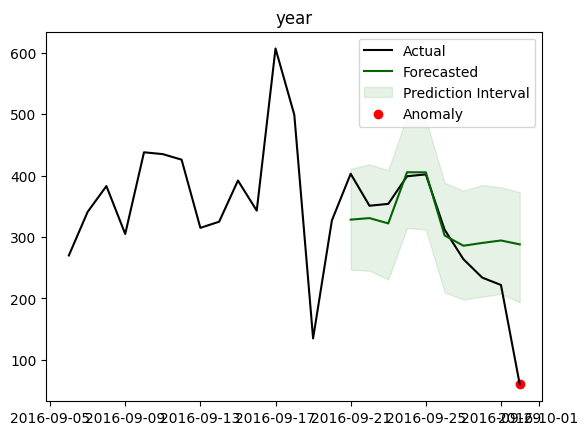

In [224]:
for i in range(len(forecasts)):
    forecasts[i]['ds'] = pd.to_datetime(forecasts[i]['ds'])
    results = local_ts[-25:].merge(forecasts[i][['ds', 'yhat', 'yhat_lower', 'yhat_upper']].astype(local_ts[['ds']].dtypes.to_dict()), how = 'outer', left_on = 'ds', right_on = 'ds')
    anomaly = results[(results['y'] < results['yhat_lower']) | (results['y'] > results['yhat_upper'])]
    fig, ax = plt.subplots()
    ax.set_title(f'{history_sizes[i][0]}')
    ax.plot(results['ds'], results['y'], color = 'black', label = 'Actual')
    ax.plot(results['ds'], results['yhat'], color = 'darkgreen', label = 'Forecasted')
    ax.fill_between(results['ds'], results['yhat_lower'], results['yhat_upper'], color = 'green', alpha = .1, label = 'Prediction Interval')
    ax.scatter(anomaly['ds'], anomaly['y'], color = 'red', label = 'Anomaly')
    ax.legend(loc='best')
    fig.show()

### Scaling The Endpoint

Build a function that takes three inputs:
- batch_size is the number of instances per request
- concur_requests is the number of simoultaneous prediction request to open
- total_instances is the total number of instances to predict 

In other words, use `concur_request` simoultaneous request of size `batch_size` until `total_instances` have been predicted.

In [129]:
import asyncio
import time

In [140]:
input_ts = input_ts[0]

In [142]:
# use the async client for the endpoint
client_options = {"api_endpoint": f"{REGION}-aiplatform.googleapis.com"}
parent = f"projects/{PROJECT_ID}/locations/{REGION}"

client = aiplatform.gapic.PredictionServiceAsyncClient(client_options = client_options)

In [143]:
async def asyncPredictions(batch_size = 1, concur_requests = 10, total_instances = 100):
    limit = asyncio.Semaphore(concur_requests)
    instance = [input_ts]
    predictions = [None] * total_instances

    async def predictor(p, batch_size):
        async with limit:
            if limit.locked():
                await asyncio.sleep(.01)
            prediction = await client.predict(
                endpoint = endpoint.resource_name, 
                instances = instance * batch_size,
                #retry = my_retry_policy,
                timeout = 100000
            )

        predictions[p:p+batch_size] = prediction.predictions

    async def runner(batch_size, total_instances):
        tasks = []
        for p in range(0, total_instances, batch_size):
            task = asyncio.create_task(predictor(p, batch_size))
            tasks.append(task)
        results = await asyncio.gather(*tasks)

    start = time.perf_counter()
    await runner(batch_size, total_instances)
    elapsed = time.perf_counter() - start
    print(f'{elapsed:0.5f} seconds')
    
    return predictions

In [144]:
# 2 request of 1 instance each until 10 complete
predictions = await asyncPredictions(1, 2, 10)

2.56212 seconds


In [145]:
# 10 request of 1 instance each until 20 complete
predictions = await asyncPredictions(1, 10, 20)

4.64986 seconds


In [146]:
# 10 request of 2 instances each until 20 complete
predictions = await asyncPredictions(2, 10, 20)

5.18649 seconds


In [148]:
# 5 request of 2 instances each until 100 complete
predictions = await asyncPredictions(2, 5, 100)

35.80268 seconds


In [602]:
# 5 request of 2 instances each until 100 complete
predictions = await asyncPredictions(2, 5, 200)

29.93182 seconds


In [603]:
# 6 request of 2 instances each until 100 complete
predictions = await asyncPredictions(2, 6, 200)

27.71497 seconds


In [604]:
# 7 request of 2 instances each until 100 complete
predictions = await asyncPredictions(2, 7, 200)

26.66344 seconds


In [609]:
# 10 request of 2 instances each until 100 complete
predictions = await asyncPredictions(2, 10, 200)

26.86186 seconds


The screenshots below show the endpoint performance and resources values during the tests above.  Notice the endpoint scales from 1 replica to 3 (the max set at creation above).  Also, as the endpoint scales the latency drops!

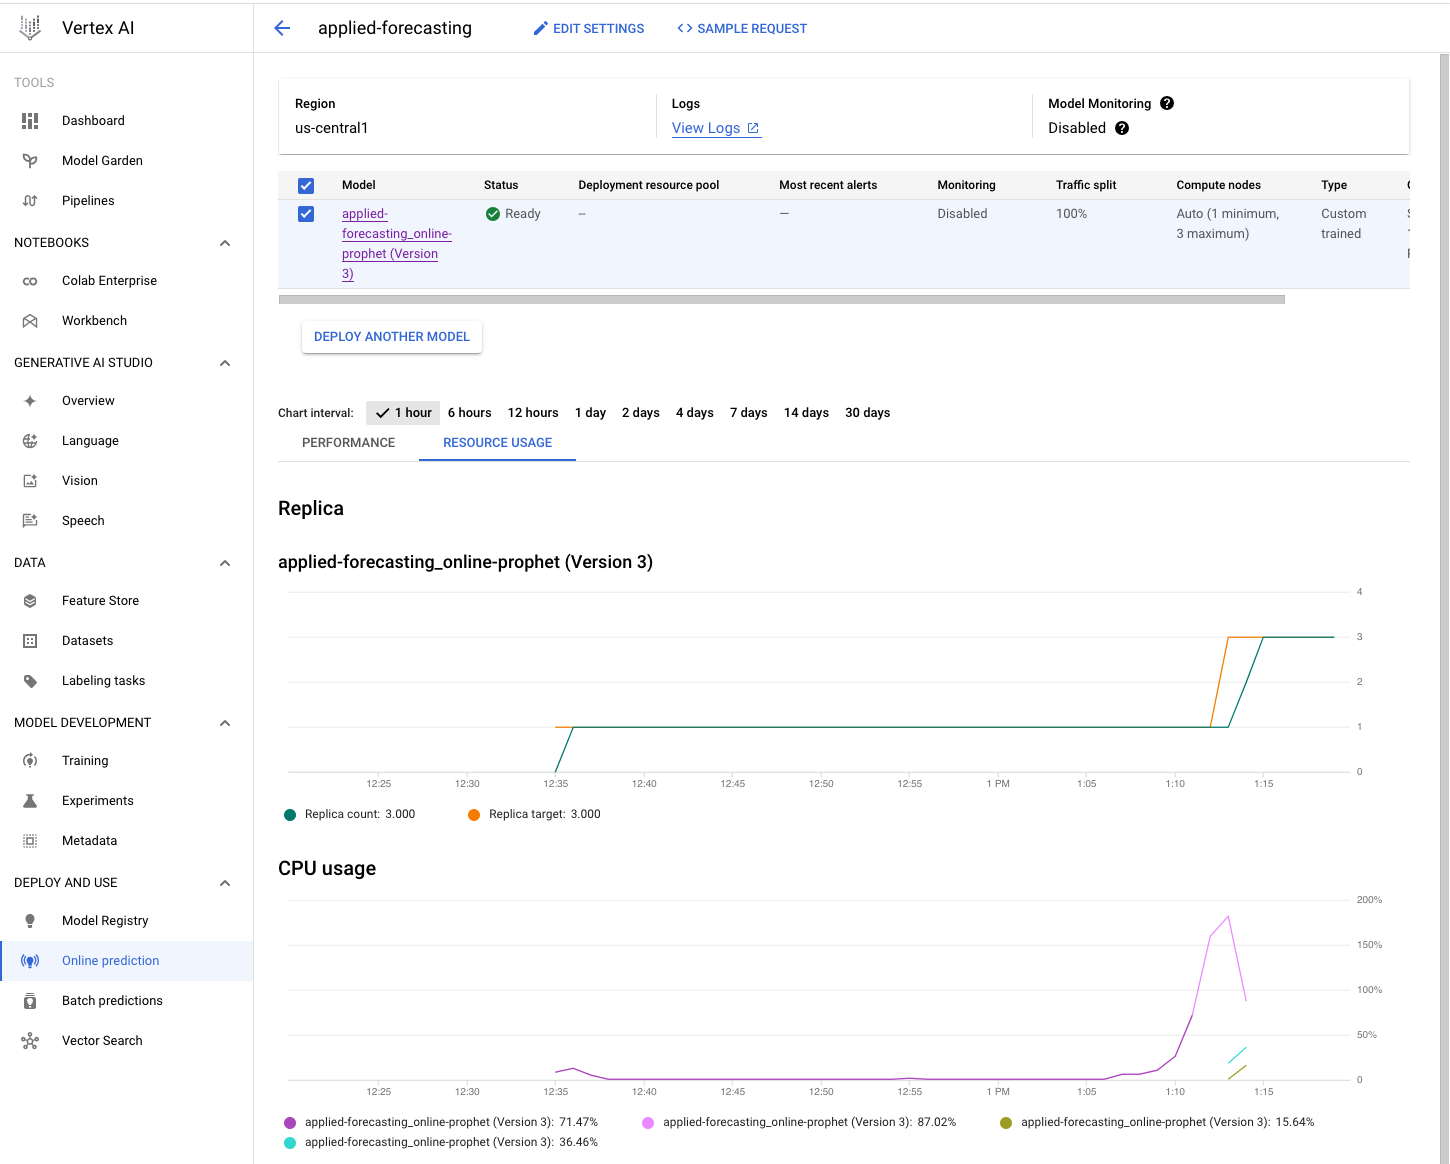

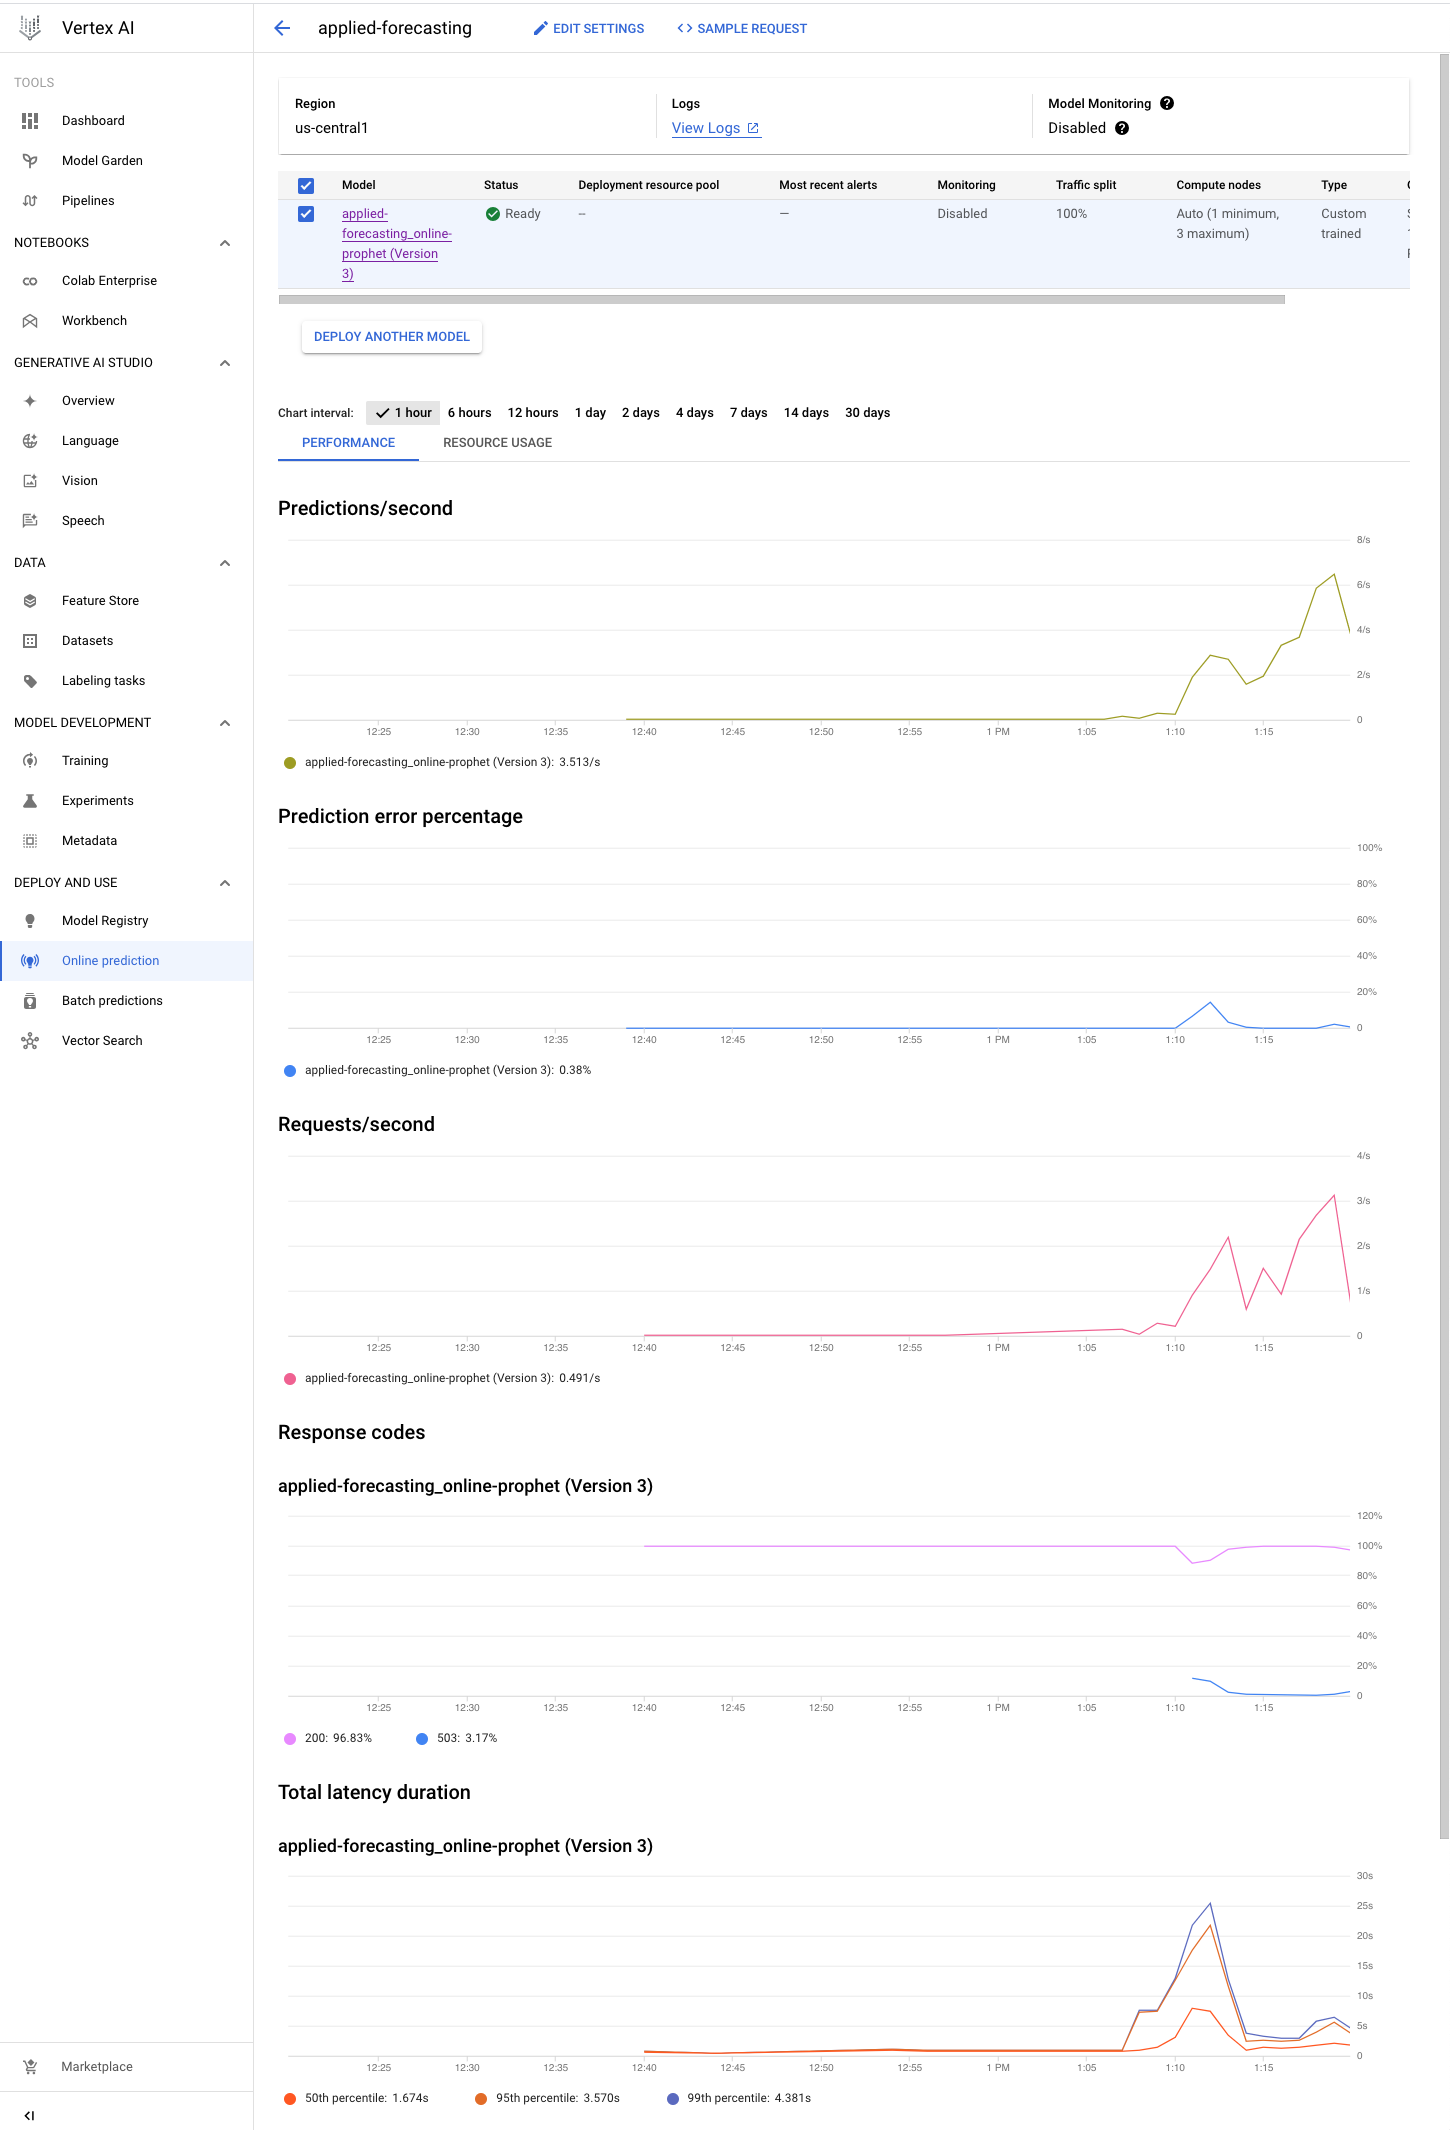

---
## Remove Resources

The endpoint will continue to run unless it is stopped:

In [149]:
#endpoint.delete(force = True)

Undeploying Endpoint model: projects/1026793852137/locations/us-central1/endpoints/4017987122823692288


[INFO][2023-09-12 13:14:21,458][google.cloud.aiplatform.models] Undeploying Endpoint model: projects/1026793852137/locations/us-central1/endpoints/4017987122823692288


Undeploy Endpoint model backing LRO: projects/1026793852137/locations/us-central1/endpoints/4017987122823692288/operations/9173799112007483392


[INFO][2023-09-12 13:14:21,556][google.cloud.aiplatform.models] Undeploy Endpoint model backing LRO: projects/1026793852137/locations/us-central1/endpoints/4017987122823692288/operations/9173799112007483392


Endpoint model undeployed. Resource name: projects/1026793852137/locations/us-central1/endpoints/4017987122823692288


[INFO][2023-09-12 13:14:21,559][google.cloud.aiplatform.models] Endpoint model undeployed. Resource name: projects/1026793852137/locations/us-central1/endpoints/4017987122823692288


Deleting Endpoint : projects/1026793852137/locations/us-central1/endpoints/4017987122823692288


[INFO][2023-09-12 13:14:21,628][google.cloud.aiplatform.base] Deleting Endpoint : projects/1026793852137/locations/us-central1/endpoints/4017987122823692288


Delete Endpoint  backing LRO: projects/1026793852137/locations/us-central1/operations/7060484986863878144


[INFO][2023-09-12 13:14:21,710][google.cloud.aiplatform.base] Delete Endpoint  backing LRO: projects/1026793852137/locations/us-central1/operations/7060484986863878144


Endpoint deleted. . Resource name: projects/1026793852137/locations/us-central1/endpoints/4017987122823692288


[INFO][2023-09-12 13:14:21,712][google.cloud.aiplatform.base] Endpoint deleted. . Resource name: projects/1026793852137/locations/us-central1/endpoints/4017987122823692288
